<a href="https://colab.research.google.com/github/Valdi35/Detect-HFT-traders-Machine-learning-/blob/main/HFT_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Le but du challenge est de construire un modèle de machine learning pouvant prédire les trois catégories de traders (HFT, non HFT et MIX). Au delà d'obtenir une meilleure accuracy, le second objectif consiste à choisir les variables les plus pertinentes.

In [ ]:
#Download libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import scipy.stats as stats
import math
from math import inf

In [ ]:
df = pd.read_csv('AMF_train_X.csv')
y_train = pd.read_csv('AMF_train_Y.csv')

In [ ]:
df.columns= df.columns.str.lower()
y_train.columns = y_train.columns.str.lower()

In [ ]:
df.head()

,index,share,day,trader,otr,ocr,omr,min_time_two_events,mean_time_two_events,10_p_time_two_events,...,min_dt_tv1_tv2,mean_dt_tv1_tv2,med_dt_tv1_tv2,min_dt_tv1_tv3,mean_dt_tv1_tv3,med_dt_tv1_tv3,min_dt_tv1_tv4,mean_dt_tv1_tv4,med_dt_tv1_tv4,nbsecondwithatleatonetrade
0,1,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,2,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
2,3,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
3,4,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,5,Isin_87,Date_9,Trader_10,1.517730,26.750000,NaN,0.0,944.008551,0.000071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38


In [ ]:
y_train.head()

,trader,type
0,Trader_285,MIX
1,Trader_114,NON HFT
2,Trader_110,NON HFT
3,Trader_57,NON HFT
4,Trader_128,NON HFT


In [ ]:
#Join the two df on trader id
data = pd.merge(df, y_train, how="inner", on=["trader"])

List of features
x_Train and x_test data exhibit in their rows the same 35 features calculated for a given market player i on a certain stock Isin_iIsin 
i
​	
  (whose identification code is an Isin) and a specific trading date tt :


- Number of trading venues on which the market player trades ;

- From all trading venues, statistics over the number of trades observed per second : #2 the mean, and, the max

- Statistics over the observed time delta between two trades on the trading venue TV_1[1] : min, median, mean

Statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_2 : min, median, mean

- Statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_3 : min, median, mean

- Statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_4 : min, median, mean

- From all trading venues, number of seconds during the trading day where at least one trade of the market player i is observed
on trading venue TV_1;

- Three ratios between the number of all types of events[2] sent to the LOB and :
the number of trades (OTR),
the number of cancellation-type event (OCR),
the number of modification-type event (OMR);

- On trading venue TV_1, statistics over the observed time delta between two all-type events sent :
min,
mean,
10th percentile,
1st quartile,
median,
3rd quartile,
90th percentile,
max

- On trading venue TV_1, statistics over the observed lifetime of cancelled orders :
min,
mean,
10th percentile,
1st quartile,
median,
3rd quartile,
90th percentile,
max

The features above are not detailed in the same order as in the challenge files.


[1] TV_1 is the trading venue with the highest volume traded
[2] Events include both the transactions and the messages that market players can send to the LOB: new order, order modification or order cancellation.

In [ ]:
def freq(x, pas= 0.1):
  """ calculate frequency in each category """
  q = np.unique(np.quantile(x, pas))
  qx = pd.cut(x,q,include_lowest=True)
  tab = pd.crosstab(x, df["type"], dropna=False)
  f = tab/tab.sum()
  return f

In [ ]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105782 entries, 0 to 105781
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   index                       105782 non-null  int64  
 1   share                       105782 non-null  object 
 2   day                         105782 non-null  object 
 3   trader                      105782 non-null  object 
 4   otr                         104099 non-null  float64
 5   ocr                         105782 non-null  float64
 6   omr                         58170 non-null   float64
 7   min_time_two_events         105782 non-null  float64
 8   mean_time_two_events        105782 non-null  float64
 9   10_p_time_two_events        105782 non-null  float64
 10  med_time_two_events         105782 non-null  float64
 11  25_p_time_two_events        105782 non-null  float64
 12  75_p_time_two_events        105782 non-null  float64
 13  90_p_time_two_

In [ ]:
#Remove columns with null values more than a threeshold (0.2)
df.isnull().mean()

index                         0.000000
share                         0.000000
day                           0.000000
trader                        0.000000
otr                           0.015910
ocr                           0.000000
omr                           0.450095
min_time_two_events           0.000000
mean_time_two_events          0.000000
10_p_time_two_events          0.000000
med_time_two_events           0.000000
25_p_time_two_events          0.000000
75_p_time_two_events          0.000000
90_p_time_two_events          0.000000
max_time_two_events           0.000000
min_lifetime_cancel           0.000000
mean_lifetime_cancel          0.000000
10_p_lifetime_cancel          0.000000
med_lifetime_cancel           0.000000
25_p_lifetime_cancel          0.000000
75_p_lifetime_cancel          0.000000
90_p_lifetime_cancel          0.000000
max_lifetime_cancel           0.000000
nbtradevenuemic               0.000000
maxnbtradesbysecond           0.000000
meannbtradesbysecond     

In [ ]:
df = df[df.columns[df.isnull().mean() < 0.2]]

In [ ]:
del df['index']
df.head()

,share,day,trader,otr,ocr,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,90_p_lifetime_cancel,max_lifetime_cancel,nbtradevenuemic,maxnbtradesbysecond,meannbtradesbysecond,min_dt_tv1,mean_dt_tv1,med_dt_tv1,nbsecondwithatleatonetrade,type
0,Isin_8,Date_24,Trader_10,2.272727,8.333333,0.0,5117.830300,0.000000,419.688500,10.722543,...,23151.8380,23151.838,1,7,2.750000,351.702399,9639.216031,1585.079495,4,NON HFT
1,Isin_87,Date_29,Trader_10,1.696629,25.166667,0.0,1846.968401,0.000074,0.003374,0.000204,...,21433.6840,21433.684,1,17,5.933333,0.000066,493.559196,0.000901,15,NON HFT
2,Isin_87,Date_23,Trader_10,1.482759,47.300000,0.0,686.300630,0.000071,0.000599,0.000129,...,1953.6235,10842.464,1,20,5.063492,0.000018,163.954785,0.000770,63,NON HFT
3,Isin_12,Date_11,Trader_10,1.705882,14.500000,0.0,2174.335265,0.000000,6.152666,0.000945,...,19187.7190,19187.719,1,8,4.250000,0.000148,1232.562133,0.004301,4,NON HFT
4,Isin_87,Date_9,Trader_10,1.517730,26.750000,0.0,944.008551,0.000071,0.001364,0.000146,...,23164.5140,23164.514,1,19,3.710526,0.000025,248.073927,0.001364,38,NON HFT


Anova test

In [ ]:
#anova test
numerical_column = ['int64','float64'] 

#We want to know if the mean trade by second is the same in each category

# random sample for 50 trader 
unique_trader_id = list(df['trader'].unique())
random.seed(30) 

sample_trader_id = random.sample(unique_trader_id, 50)
sample_df = df[df['trader'].isin(sample_trader_id)].reset_index(drop=True)

In [ ]:
sample_df.head()

,share,day,trader,otr,ocr,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,90_p_lifetime_cancel,max_lifetime_cancel,nbtradevenuemic,maxnbtradesbysecond,meannbtradesbysecond,min_dt_tv1,mean_dt_tv1,med_dt_tv1,nbsecondwithatleatonetrade,type
0,Isin_8,Date_24,Trader_10,2.272727,8.333333,0.0,5117.830300,0.000000,419.688500,10.722543,...,23151.8380,23151.838,1,7,2.750000,351.702399,9639.216031,1585.079495,4,NON HFT
1,Isin_87,Date_29,Trader_10,1.696629,25.166667,0.0,1846.968401,0.000074,0.003374,0.000204,...,21433.6840,21433.684,1,17,5.933333,0.000066,493.559196,0.000901,15,NON HFT
2,Isin_87,Date_23,Trader_10,1.482759,47.300000,0.0,686.300630,0.000071,0.000599,0.000129,...,1953.6235,10842.464,1,20,5.063492,0.000018,163.954785,0.000770,63,NON HFT
3,Isin_12,Date_11,Trader_10,1.705882,14.500000,0.0,2174.335265,0.000000,6.152666,0.000945,...,19187.7190,19187.719,1,8,4.250000,0.000148,1232.562133,0.004301,4,NON HFT
4,Isin_87,Date_9,Trader_10,1.517730,26.750000,0.0,944.008551,0.000071,0.001364,0.000146,...,23164.5140,23164.514,1,19,3.710526,0.000025,248.073927,0.001364,38,NON HFT


In [ ]:
# variables of interest
var = ['otr', 'ocr','nbtradevenuemic','maxnbtradesbysecond','nbsecondwithatleatonetrade','type']
sample_df = sample_df[var].fillna(0)
groups = sample_df.groupby('type').count().reset_index()
groups

,type,otr,ocr,nbtradevenuemic,maxnbtradesbysecond,nbsecondwithatleatonetrade
0,HFT,29068,29068,29068,29068,29068
1,MIX,22087,22087,22087,22087,22087
2,NON HFT,14592,14592,14592,14592,14592


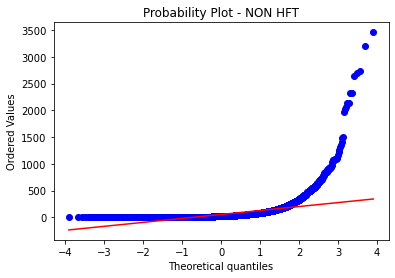

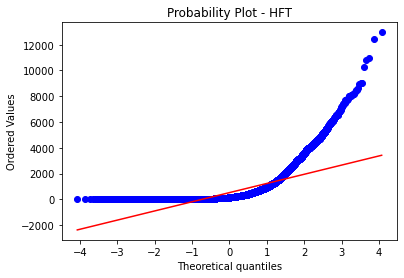

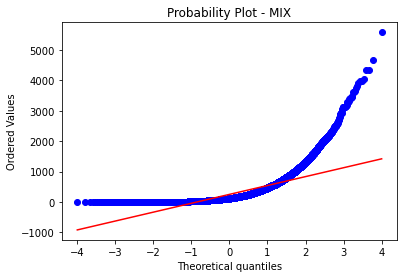

In [ ]:
#Normality assumption
unique_category = sample_df['type'].unique()
for i in unique_category:
    stats.probplot(sample_df[sample_df['type'] == i]['nbsecondwithatleatonetrade'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  i)
    plt.show()

Data are not normally distributed

In [ ]:
# calculate ratio of the largest to the smallest sample standard deviation
ratio = sample_df.groupby('type').std().max() / sample_df.groupby('type').std().min()
if ratio.max() / ratio.min() > 2:
    print('The ratio is more than the threshold of 2, not fulfilled the assumption of similar variance between categories')

The ratio is more than the threshold of 2, not fulfilled the assumption of similar variance between categories


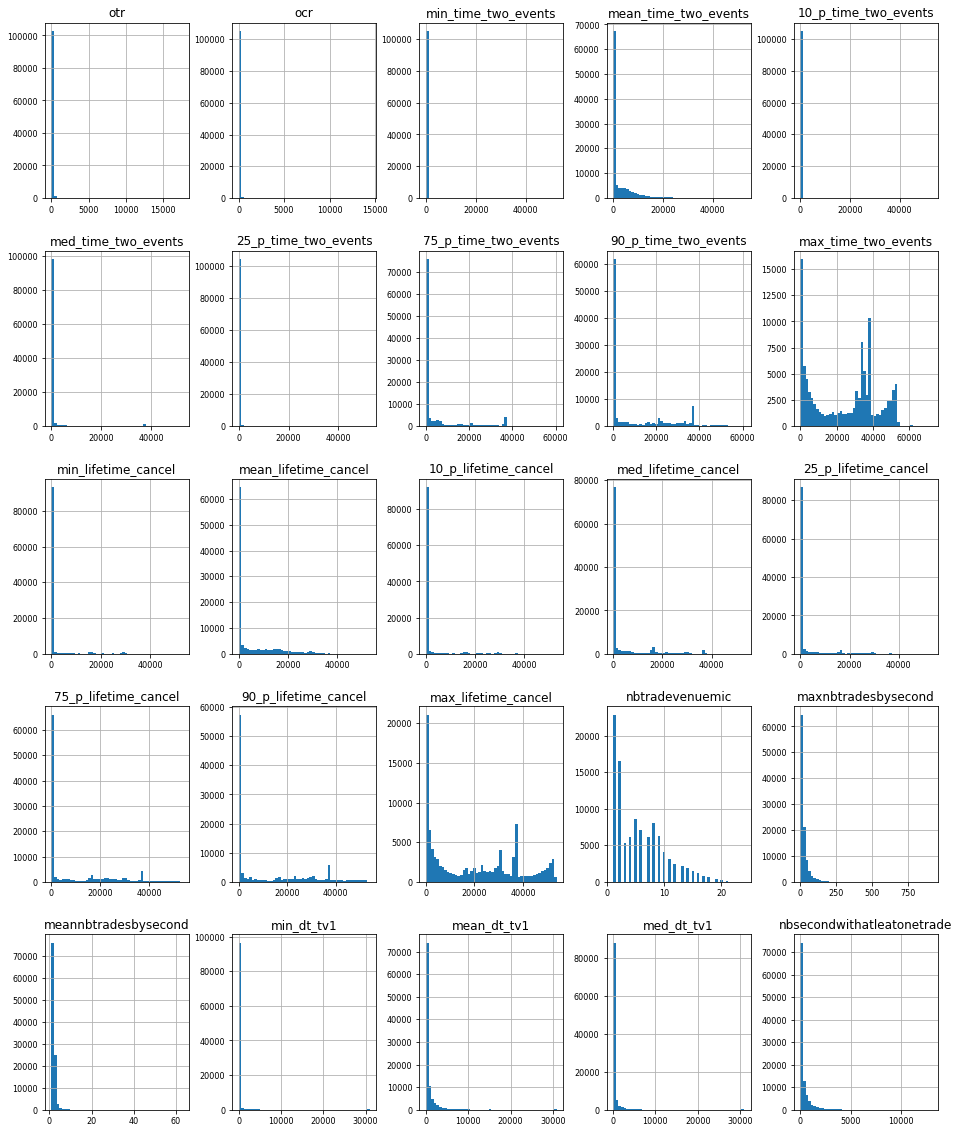

In [ ]:
df.select_dtypes(include=numerical_column).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

Skweness

In [ ]:
def replace_nan(data):
    #Replace NaN values by the mean of each unique trader
    data = data.select_dtypes(include=['int64','float64'])
    column_means = data.mean()
    data = data.fillna(column_means)
    return data

In [ ]:
df_num = df.select_dtypes(include=numerical_column)

In [ ]:
df_num = replace_nan(df)

In [ ]:
#Calcul of each feature skweness
""""skewness = 0 : normally distributed.
skewness > 0 : more weight in the left tail of the distribution.
skewness < 0 : more weight in the right tail of the distribution."""

def skewness(data):
    from scipy.stats import skew
    data = pd.DataFrame(data=skew(data), index=data.columns, columns=['asymetry'])
    data = data.fillna(0)
    return data

skew_data = skewness(df_num)
skew_data

,asymetry
otr,43.910162
ocr,84.852699
min_time_two_events,22.558962
mean_time_two_events,2.842827
10_p_time_two_events,20.998609
med_time_two_events,6.298088
25_p_time_two_events,13.658408
75_p_time_two_events,2.483106
90_p_time_two_events,1.195520
max_time_two_events,-0.054779


In [ ]:
to_left = skew_data[skew_data['asymetry']>0].index.tolist() 
to_right = skew_data[skew_data['asymetry']<0].index.tolist() 

In [ ]:
def pos_correction(data):
    data = np.log(data)
    return data

def neg_correction(data):
    data = np.exp(data)
    return data

In [ ]:
df[to_left] = pos_correction(df[to_left])
df[to_right] = neg_correction(df[to_right])

In [ ]:
df.head()

,share,day,trader,otr,ocr,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,90_p_lifetime_cancel,max_lifetime_cancel,nbtradevenuemic,maxnbtradesbysecond,meannbtradesbysecond,min_dt_tv1,mean_dt_tv1,med_dt_tv1,nbsecondwithatleatonetrade,type
0,Isin_8,Date_24,Trader_10,0.820981,2.120264,-inf,8.540486,-inf,6.039513,2.372348,...,10.049829,10.049829,0.0,1.945910,1.011601,5.862785,9.173595,7.368390,1.386294,NON HFT
1,Isin_87,Date_29,Trader_10,0.528643,3.225520,-inf,7.521301,-9.511445,-5.691656,-8.497391,...,9.972719,9.972719,0.0,2.833213,1.780586,-9.625856,6.201643,-7.012005,2.708050,NON HFT
2,Isin_87,Date_23,Trader_10,0.393904,3.856510,-inf,6.531316,-9.552831,-7.420249,-8.955698,...,7.577441,9.291226,0.0,2.995732,1.622056,-10.925139,5.099591,-7.169120,4.143135,NON HFT
3,Isin_12,Date_11,Trader_10,0.534082,2.674149,-inf,7.684478,-inf,1.816885,-6.964326,...,9.862026,9.862026,0.0,2.079442,1.446919,-8.818298,7.116850,-5.448908,1.386294,NON HFT
4,Isin_87,Date_9,Trader_10,0.417216,3.286534,-inf,6.850135,-9.552831,-6.597334,-8.831904,...,10.050377,10.050377,0.0,2.944439,1.311174,-10.596635,5.513727,-6.597334,3.637586,NON HFT


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df = df.fillna(0)

EDA

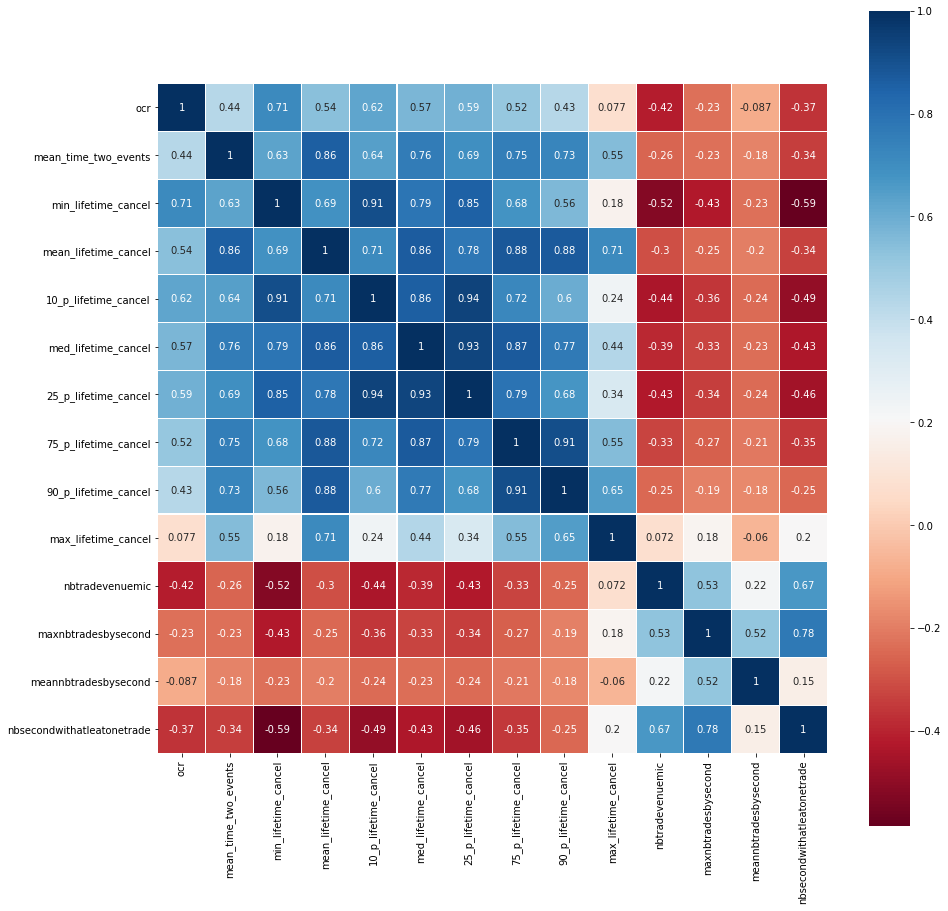

In [ ]:
#select only numerical features to find correlation
plt.figure(figsize=(15,15))
sns.heatmap(
    df.select_dtypes(include=numerical_column).corr(),
    cmap=plt.cm.RdBu,
    vmax=1.0,
    linewidths=0.1,
    linecolor='white',
    square=True,
    annot=True
)
plt.show()

In [ ]:
def correlation(dataset, threshold):
  #Remove correlated features
  col_corr = set() 
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [ ]:
corr_features = correlation(df.iloc[:,~df.columns.isin(['day', 'trader', 'type', 'share'])], 0.7)

In [ ]:
#statistics calculated by AMF on lifetime cancel are highly correlated
corr_features

{'10_p_lifetime_cancel',
 '25_p_lifetime_cancel',
 '75_p_lifetime_cancel',
 '90_p_lifetime_cancel',
 'max_lifetime_cancel',
 'mean_lifetime_cancel',
 'med_lifetime_cancel',
 'min_lifetime_cancel',
 'nbsecondwithatleatonetrade'}

In [ ]:
#Drop correlated features
df = df.drop(corr_features,axis=1)
#L'apport marginal de chaque predicteur
#decroit en presence de correlation lineaire

from all trading venues, number of seconds during the trading day where at least one trade of the market player i is observed on trading venue TV_1

In [ ]:
df = df.set_index('trader')

Modelling

In [ ]:
X = df.loc[:,df.columns != 'type']
Y = df['type']

#encode target variables with pd get dummies
Y = pd.get_dummies(Y)

In [ ]:
#data to train
#X = X.loc[:,~X.columns.isin(['share','day'])]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#Build model to predict data
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, Y)
scores = cross_val_score(
    clf, X, Y, cv=5, scoring='f1_macro')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

TypeError: float() argument must be a string or a number, not 'method'

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(str(model_type) + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


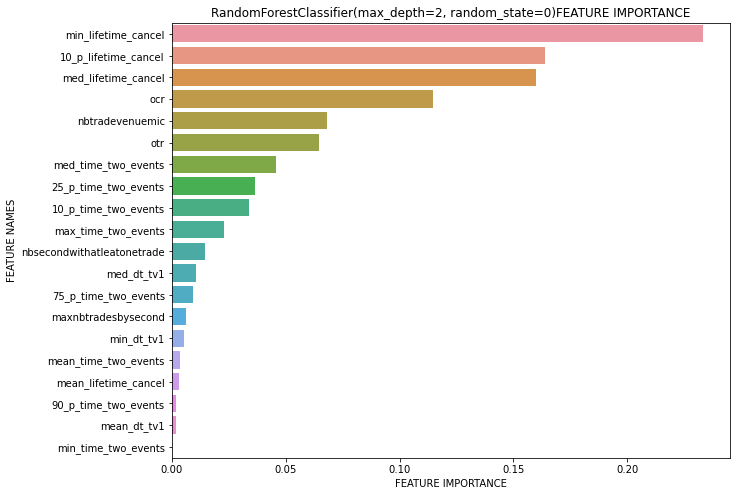

In [ ]:
plot_feature_importance(clf.feature_importances_, X.columns, clf)

Feature engineering